In [4]:
# GHZ with error correction with stablizer code

# We test for five qubits.
# Idea: we use even qubits as stabilizers for error correction

In [5]:
from typing import List, Optional

from qiskit import transpile, QuantumCircuit, QuantumRegister, ClassicalRegister

quantum_register = QuantumRegister(5)
classical_register = ClassicalRegister(5)

initial_layout = [
    
    0,1,2,3,4
    
]
ghz_qubits = [
    
0,2,4
   
]
stabilizer_qubits = [
    
1,3
    
]

In [6]:
def generate():
    qc = QuantumCircuit(quantum_register, classical_register)

    qc.h(2)

    qc.cx(2, 1)

    qc.cx(1, 0)
    qc.cx(2, 3)

    qc.cx(3, 4)

    return qc


ghz_circuit = generate()
print(ghz_circuit.depth())

4


In [7]:
def deentangle():
    qc = QuantumCircuit(quantum_register, classical_register)

    qc.cx(0, 1)

    qc.cx(4, 3)
    return qc


unentangle_circuit = deentangle()
print(unentangle_circuit.depth())

complete_circuit = ghz_circuit.compose(unentangle_circuit)

1


In [8]:
def stabilizers_meas():
    qc = QuantumCircuit(quantum_register, classical_register)
    qc.measure(stabilizer_qubits, stabilizer_qubits)
    return qc


stabilizer_circuit = stabilizers_meas()

In [11]:
def ghz_meas():
    qc = QuantumCircuit(quantum_register, classical_register)
    qc.measure(ghz_qubits, ghz_qubits)
    return qc


measure_circuit = ghz_meas()

In [12]:
simple_ghz = (
    ghz_circuit.compose(unentangle_circuit)
    .compose(stabilizer_circuit)
    .compose(measure_circuit)
)

In [13]:
from qiskit.providers.fake_provider import FakeManila
from qiskit import transpile

backend = FakeManila()
qc_transpiled = transpile(simple_ghz, backend, initial_layout=initial_layout)

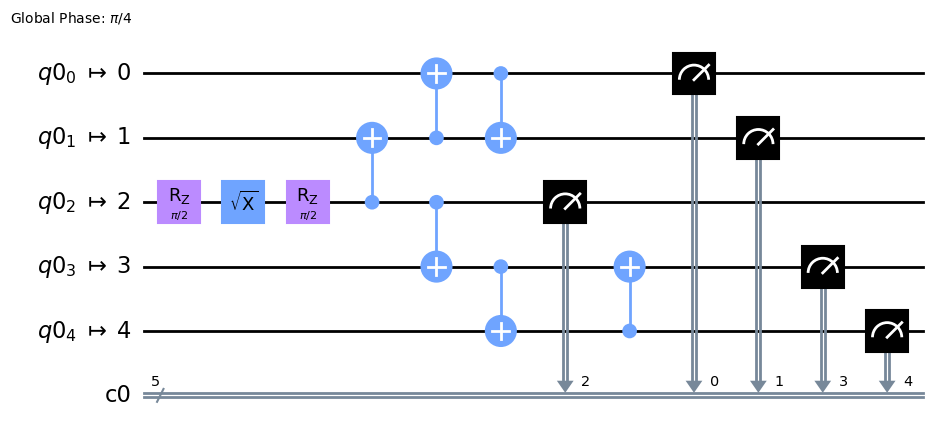

In [14]:
qc_transpiled.draw()

In [15]:
job = backend.run(
    qc_transpiled,
    shots=1024,
    memory=True,
)

data = job.result().get_memory()

print(data)

['00000', '00000', '10101', '00000', '00000', '00000', '10101', '00000', '00000', '00000', '00000', '00000', '10101', '00000', '00000', '10100', '00000', '00000', '00000', '00000', '00000', '10101', '00001', '10100', '10101', '10000', '00000', '00001', '00000', '00100', '00000', '10101', '00000', '10101', '10101', '10101', '10101', '00000', '10101', '10101', '10101', '10101', '00000', '00000', '10100', '00001', '00101', '10101', '00000', '10000', '00000', '10101', '00000', '10101', '00000', '10101', '10101', '00000', '10101', '10100', '10001', '10101', '10101', '00000', '00000', '00000', '10100', '00000', '00001', '10101', '00000', '10100', '00000', '10101', '00000', '00000', '00000', '10101', '10101', '10100', '10100', '10101', '00100', '10100', '10101', '00000', '00000', '00000', '10101', '00000', '00000', '11001', '10100', '10101', '10101', '10001', '00000', '10100', '00000', '00000', '00000', '10101', '10101', '00000', '00000', '10101', '00000', '00000', '10101', '00000', '10100', 

In [ ]:
# A function to test the quality of a GHZ-state. The lower the better
def test_ghz(data):
    ghz_qubits = [
        0,
        2,
        4,
    ]
    quality_list = []
    average = 0
    best = len(data)
    worst = 0

    for result in data:
        count_zeroes = 0
        count_ones = 0
        bit_count = -1
        for bit in result:
            bit_count = bit_count + 1
            if bit_count not in ghz_qubits:
                continue
            if bit == "0":
                count_zeroes = count_zeroes + 1
            else:
                count_ones = count_ones + 1
        if count_ones < count_zeroes:
            count_zeroes = count_ones

        quality_list.append(count_zeroes)
        average = average + count_zeroes

        if count_zeroes > worst:
            worst = count_zeroes
        if count_zeroes < best:
            best = count_zeroes

    average = average / len(data)
    print(average)
    print(worst)
    print(best)
    return average


test_ghz(data)

In [16]:
def correct_ghz():
    qc = QuantumCircuit(quantum_register, classical_register)


    with qc.if_test((classical_register[3], 1)):
        qc.x(quantum_register[3])


    with qc.if_test((classical_register[1], 1)):
        qc.x(quantum_register[1])

    return qc


correcting_circuit = correct_ghz()

In [ ]:
error_corrected_ghz = (
    ghz_circuit.compose(unentangle_circuit)
    .compose(stabilizer_circuit)
    .compose(correcting_circuit)
    .compose(measure_circuit)
)

In [ ]:
print(error_corrected_ghz.depth())

In [ ]:
result = backend.run(error_corrected_ghz, shots=1024).result()
print(result.get_counts())

In [ ]:
from qiskit.visualization import plot_histogram

plot_histogram(result.get_counts(), sort='value_desc')